In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import gzip

import matplotlib

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
matplotlib.rc('text',  usetex=True)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
NUM_SAMPLES=float(1<<10)
NOISE_FLOOR=-92
INDEX="time"

CCA=0
CCA_OVERRIDE={}

START={}

In [3]:
from enum import Enum
    
class Chanspec:
    WL_CHANSPEC_CHAN_MASK=0x00ff

    WL_CHANSPEC_BW_MASK=0x3800
    class Bandwidth(Enum):
        WL_CHANSPEC_BW_5=0x0000
        WL_CHANSPEC_BW_10=0x0800
        WL_CHANSPEC_BW_20=0x1000
        WL_CHANSPEC_BW_40=0x1800
        WL_CHANSPEC_BW_80=0x2000
        WL_CHANSPEC_BW_160=0x2800
        WL_CHANSPEC_BW_8080=0x3000
    
    WL_CHANSPEC_BAND_MASK=0xc000
    class Band(Enum):
        WL_CHANSPEC_BAND_2G=0x0000
        WL_CHANSPEC_BAND_3G=0x4000
        WL_CHANSPEC_BAND_4G=0x8000
        WL_CHANSPEC_BAND_5G=0xc000
        
    def __init__(self,chanspec):
        self.channel=chanspec&self.WL_CHANSPEC_CHAN_MASK
        self.bandwidth=self.Bandwidth(chanspec&self.WL_CHANSPEC_BW_MASK)
        self.band=self.Band(chanspec&self.WL_CHANSPEC_BAND_MASK)
        
    def __repr__(self):
        return "Channel: %d, Bandwidth %s, Band %s"%(self.channel,self.bandwidth.name,self.band.name)

WL_CHANSPEC_BAND_SHIFT=14

In [4]:
dfs=[{},{},{}]
runs=[{},{},{}]

runs[0]["rpi93"]="rpi93/rssi-1590772557.csv.gz"
runs[0]["rpi91"]="rpi91/rssi-1590772555.csv.gz"
runs[0]["rpi92"]="rpi92/rssi-1590772558.csv.gz"
runs[0]["rpi94"]="rpi94/rssi-1590772558.csv.gz"
runs[0]["rpi90"]="rpi90/rssi-1590772554.csv.gz"

runs[1]["rpi93"]="rpi93/rssi-1590773514.csv.gz"
runs[1]["rpi91"]="rpi91/rssi-1590773517.csv.gz"
runs[1]["rpi92"]="rpi92/rssi-1590773517.csv.gz"
runs[1]["rpi94"]="rpi94/rssi-1590773516.csv.gz"
runs[1]["rpi90"]="rpi90/rssi-1590773517.csv.gz"

runs[2]["rpi93"]="rpi93/rssi-1590775561.csv.gz"
runs[2]["rpi91"]="rpi91/rssi-1590775560.csv.gz"
runs[2]["rpi92"]="rpi92/rssi-1590775561.csv.gz"
runs[2]["rpi94"]="rpi94/rssi-1590775562.csv.gz"
runs[2]["rpi90"]="rpi90/rssi-1590775561.csv.gz"

for i in range(0,len(runs)):
    load = runs[i]
    print("=====run%d====="%(i+1))
    for key in load.keys():
        with gzip.GzipFile(load[key]) as decompressedFile:       
            print("%s: %s"%(key,load[key]))
            dfs[i][key]=pd.read_csv(decompressedFile,parse_dates=["time"],index_col=0)  

=====run1=====
rpi93: rpi93/rssi-1590772557.csv.gz


/home/schuschu/jupyter/venv3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


rpi91: rpi91/rssi-1590772555.csv.gz
rpi92: rpi92/rssi-1590772558.csv.gz
rpi94: rpi94/rssi-1590772558.csv.gz
rpi90: rpi90/rssi-1590772554.csv.gz
=====run2=====
rpi93: rpi93/rssi-1590773514.csv.gz
rpi91: rpi91/rssi-1590773517.csv.gz
rpi92: rpi92/rssi-1590773517.csv.gz
rpi94: rpi94/rssi-1590773516.csv.gz
rpi90: rpi90/rssi-1590773517.csv.gz
=====run3=====
rpi93: rpi93/rssi-1590775561.csv.gz
rpi91: rpi91/rssi-1590775560.csv.gz
rpi92: rpi92/rssi-1590775561.csv.gz
rpi94: rpi94/rssi-1590775562.csv.gz
rpi90: rpi90/rssi-1590775561.csv.gz


In [5]:
nfs=[{},{},{}]
for i in range(0,len(runs)):
    for key in dfs[i].keys():
        df=dfs[i][key]
        nfs[i][key]=df.copy()
        nfs[i][key]["power"]=(df["power"]/NUM_SAMPLES)+NOISE_FLOOR

In [6]:
offset_time=[None,None,None]
zfs=[{},{},{}]
mfs=[{},{},{}]
for i in range(0,len(runs)):
    for key in nfs[i].keys():
        zfs[i][key]=nfs[i][key].copy(deep=True)
        if offset_time[i]==None:
            if i==2:
                offset_time[i]=zfs[i][key][zfs[i][key].power>-90][100:][zfs[i][key].power>-90]["time"].iloc[0]
            else:
                offset_time[i]=zfs[i][key][zfs[i][key].power>-80]["time"].iloc[0]
        zfs[i][key]["time"]-=offset_time[i]
        zfs[i][key]["tsf"]-=zfs[i][key]["tsf"].iloc[0]
        zfs[i][key]["time"]=zfs[i][key]["time"].dt.total_seconds()*1e3
        zfs[i][key]["tsf"]=zfs[i][key]["tsf"]/1e3
        zfs[i][key]=zfs[i][key].set_index(INDEX,drop=True)

        mfs[i][key]=zfs[i][key].copy(deep=True)
        MAX_VAL=zfs[i][key]["power"].max()
        MIN_VAL=zfs[i][key]["power"].min()

        pf=mfs[i][key].power.copy(deep=True)
        if key in CCA_OVERRIDE:
            TCCA=CCA_OVERRIDE[key]
        else:
            TCCA=CCA
        pf[pf > TCCA]=MAX_VAL
        pf[pf <= TCCA]=MIN_VAL
        mfs[i][key]["power"]=pf

/home/schuschu/jupyter/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [7]:
tzfs=[{},{},{}]
colors=["#1f77b4","#ff7f0e","#2ca02c"]

for i in range(0,3):
    for key in zfs[i].keys():
        tzfs[i][key]=zfs[i][key].reset_index(drop=False).copy()
        tzfs[i][key]["time"]/=1000
        tzfs[i][key]=tzfs[i][key].set_index("time",drop=True)

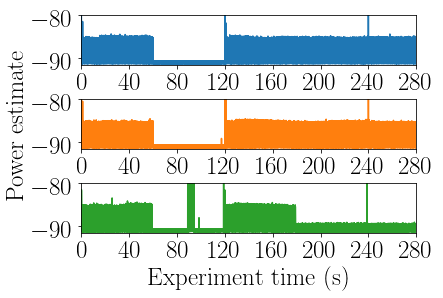

In [8]:
key="rpi94"

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

tzfs[0][key]["power"].plot(ax=ax1,color=colors[0])
tzfs[1][key]["power"].plot(ax=ax2,color=colors[1])
tzfs[2][key]["power"].plot(ax=ax3,color=colors[2])    
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax1.set_ylim(-91.5,-80)
ax2.set_ylim(-91.5,-80)
ax3.set_ylim(-91.5,-80)

xt=list(range(0,340,40))

ax1.set_xticks(xt)
ax1.set_xticklabels(xt)
ax2.set_xticks(xt)
ax2.set_xticklabels(xt)
ax3.set_xticks(xt)
ax3.set_xticklabels(xt)

ax1.set_xlim(0,280)
ax2.set_xlim(0,280)
ax3.set_xlim(0,280)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Experiment time (s)')
ax.set_ylabel('Power estimate')
fig.subplots_adjust(hspace=0.7)

In [9]:
endtime=int(zfs[0]["rpi90"].reset_index(drop=False)["time"].iloc[-1]/1000.0)
INCREMENT=1
BINS=128
MIN_RANGE=NOISE_FLOOR
MAX_RANGE=0
xs = np.linspace(NOISE_FLOOR, MAX_RANGE, num=BINS)
DENSITY=True #False

kde=[{},{},{}]
hists=[{},{},{}]

for x in range(0,endtime,INCREMENT):
    WSTART=x*1000
    WSTOP=(x+INCREMENT)*1000
    for i in range(0,len(runs)):
        kde[i][x] = {}
        hists[i][x] = {}
        for key in zfs[i].keys():
            try:
                zf=zfs[i][key]
                zf=zf.drop(zf[zf.power>0].index)

                samples=zf.loc[WSTART:WSTOP]["power"]
                hist, bins = np.histogram(samples, bins=np.linspace(NOISE_FLOOR, MAX_RANGE, BINS),density=DENSITY)
                hists[i][x][key]={"hist":hist,"bins":bins}
            except ValueError:
                pass

/home/schuschu/jupyter/venv3/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<Figure size 432x288 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


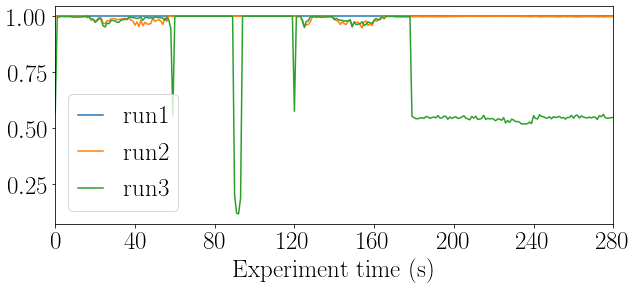

<Figure size 432x288 with 0 Axes>

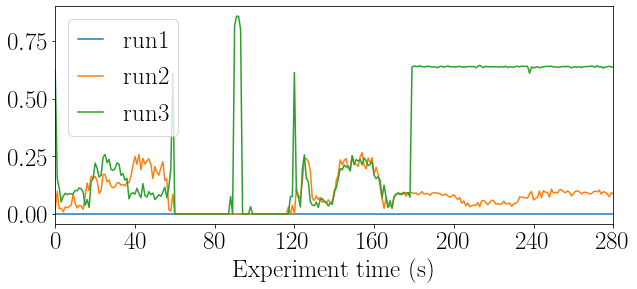

<Figure size 432x288 with 0 Axes>

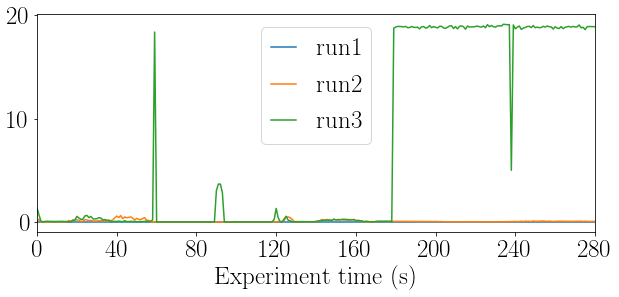

In [10]:
import cv2

def np_hist_to_cv(np_histogram_output):
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

CMPFUNS = [("Corrleation",cv2.HISTCMP_CORREL),("Hellinger distance",cv2.HISTCMP_HELLINGER),("Kullback-Leibler divergence",cv2.HISTCMP_KL_DIV)]

for CMPFUN in CMPFUNS:

    hcomp={}
    for key in ["rpi94"]:#zfs[i].keys():
        hcomp[key]=[]
    for x in range(0,endtime,INCREMENT):
        WSTART=x*1000
        WSTOP=(x+INCREMENT)*1000
        for key in ["rpi94"]: #zfs[i].keys():
            bins=hists[0][x][key]["bins"]
            h1=(hists[0][x][key]["hist"],hists[0][x][key]["bins"])
            h2=(hists[1][x][key]["hist"],hists[1][x][key]["bins"])
            h3=(hists[2][x][key]["hist"],hists[2][x][key]["bins"])
            d11 = cv2.compareHist(np_hist_to_cv(h1), np_hist_to_cv(h1),CMPFUN[1])
            d12 = cv2.compareHist(np_hist_to_cv(h1), np_hist_to_cv(h2),CMPFUN[1])
            d13 = cv2.compareHist(np_hist_to_cv(h1), np_hist_to_cv(h3),CMPFUN[1])
            hcomp[key].append({"time":x,"run1":d11,"run2":d12,"run3":d13})

    for key in ["rpi94"]:# zfs[i].keys():
        try:
            cf=pd.DataFrame(hcomp[key])
            cf=cf.set_index("time",drop=True)
            plt.figure();
            ax=cf.plot(figsize=(10,4));
            ax.set_xlabel('Experiment time (s)');
            ax.set_ylabel("");
            xt=list(range(0,340,40))
            ax.set_xticks(xt)
            ax.set_xticklabels(xt)
            ax.set_xlim(0,280)
            ax.legend(["run1","run2","run3"],handlelength=1)
        except Exception as e:
            pass

In [11]:
rf=[{},{},{}]
column_names=["Time","Level"]
rf[0]["src"]=pd.read_csv("pattern/run1/source.csv",names=column_names, header=0)
rf[0]["snk"]=pd.read_csv("pattern/run1/sink.csv",names=column_names, header=0)
rf[1]["src"]=pd.read_csv("pattern/run2/source.csv",names=column_names, header=0)
rf[1]["snk"]=pd.read_csv("pattern/run2/sink.csv",names=column_names, header=0)
rf[2]["src"]=pd.read_csv("pattern/run3/source.csv",names=column_names, header=0)
rf[2]["snk"]=pd.read_csv("pattern/run3/sink.csv",names=column_names, header=0)

crf=[{},{},{}]

for i in range(0,3):
    offset=rf[i]["src"].Time.iloc[0].copy()
    ranges = list(range(0,int(rf[i]["src"].Time.iloc[-1]-rf[i]["src"].Time.iloc[0])//1000,1))

    for n in ["src","snk"]:
        rf[i][n].Time-=offset
        rf[i][n].Time/=1000.0
        rf[i][n]=rf[i][n].set_index("Time",drop=True)
        rf[i][n]=rf[i][n].drop(rf[i][n][rf[i][n].Level==0].index)
        rf[i][n]=rf[i][n].drop(rf[i][n][rf[i][n].Level==0].index)
        crf[i][n]=rf[i][n].groupby(pd.cut(rf[i][n].index, ranges)).count()
    crf[i]["prr"]=100.0/crf[i]["src"]*crf[i]["snk"]

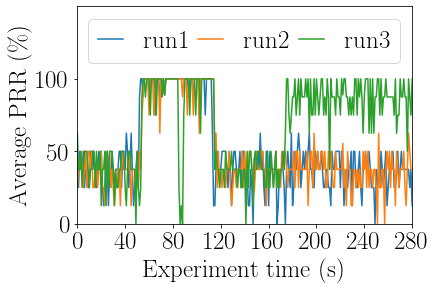

In [12]:
fig, ax = plt.subplots()
xt=list(range(0,340,40))

colors=["#1f77b4","#ff7f0e","#2ca02c"]
for i in range(0,3):
    dcf=crf[i]["prr"]
    dcf["Level"]=dcf["Level"]
    dcf["Level"].values[dcf["Level"].values > 100] = 100
    dcf["time"]=dcf.index
    dcf["time"]=dcf["time"].apply(lambda x: int(x.left))
    dcf=dcf.dropna()
    dcf=dcf.set_index("time",drop=True)
    dcf.plot(ax=ax,figsize=(6,4),color=colors[i],legend=False,rot=0)

ax.set_xticks(xt)
ax.set_xticklabels(xt)
ax.set_xlim(0,280)
ax.set_yticks([0,50,100])
ax.set_ylim(0,150)
ax.legend(["run1","run2","run3"],ncol=3,handlelength=1,columnspacing=0.4);
ax.set_xlabel('Experiment time (s)');
ax.set_ylabel('Average PRR (\%)');